<h1><center>Prediction of employees’ promotions to facilitate process expedition</center></h1>

HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources has been using analytics for years. However, the collection, processing and analysis of data has been largely manual, and given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments woke up to the utility of machine learning so late in the game. Here is an opportunity to try predictive analytics in identifying the employees most likely to get promoted.

In [ ]:
!pip install imblearn

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

## Models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
!pip install xgboost
from xgboost import XGBClassifier
import xgboost as xgb

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [11]:
from sklearn.ensemble import AdaBoostClassifier

In [12]:
train_df = pd.read_csv("train_LZdllcl.csv") # 'DataFrame' shortened to 'df'
train_df.rename(columns = {'KPIs_met >80%':'KPI_morethan_80', 'awards_won?':'awards_won'}, inplace = True)
train_df.shape

(54808, 14)

## Exploratory Data Analysis

In [13]:
train_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPI_morethan_80,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [14]:
train_df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPI_morethan_80            0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPI_morethan_80       54808 non-null  int64  
 11  awards_won            54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [16]:
train_df.describe().style.background_gradient(cmap = 'PuBuGn')

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPI_morethan_80,awards_won,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


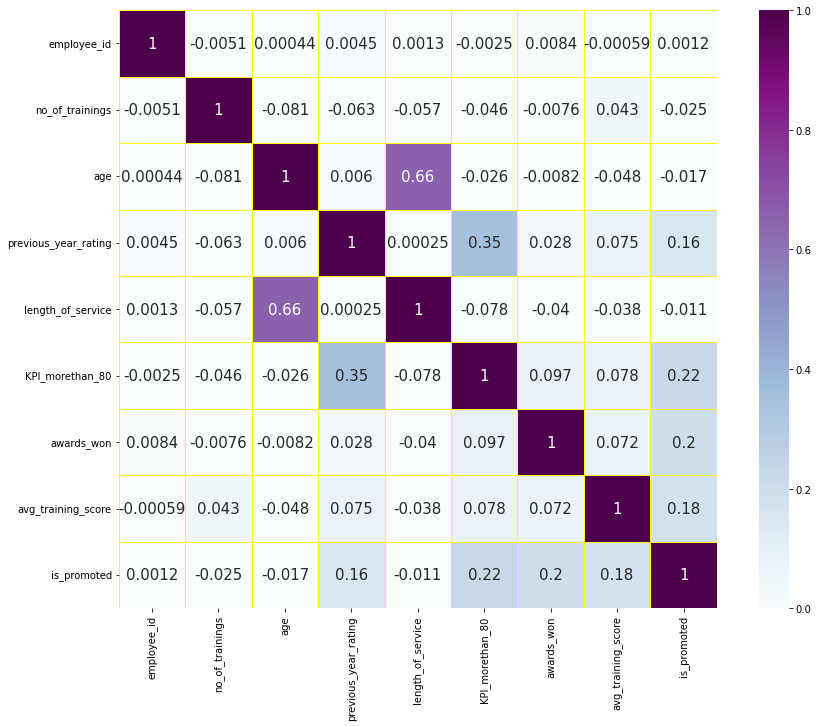

In [17]:
plt.figure(figsize=(15, 11))
sns.heatmap(train_df.corr(),cmap='BuPu',vmin=0,vmax=1,annot=True,annot_kws={'size':15},
            square=True,linewidths=1, linecolor='yellow')
plt.show()

### As we can see here the columns 'age' and 'length of service' are highly correlated since there correlation coefficient is quite close to +1. And this was expected because more the age of an employee, higher is the chance that he has served for long in the company. Although it is not necessary always but as we can see, it is the case most of the times.

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Indicate which variables to compute VIF
X = train_df[['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPI_morethan_80', 'awards_won',
       'avg_training_score', 'is_promoted']]

X.dropna(inplace=True) # vif can't be calculated with nan values
X = X._get_numeric_data()

# add intercept
X['intercept'] = 1

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,employee_id,1.000132
1,no_of_trainings,1.014395
2,age,1.638033
3,previous_year_rating,1.156960
4,length_of_service,1.642780
5,KPI_morethan_80,1.195341
6,awards_won,1.047542
7,avg_training_score,1.043556
8,is_promoted,1.123843
9,intercept,67.417187


### Testing again on the basis of Variance Inflation factor, the VIF is not even close to 5, therefore, we can conclude that there is no multicollinearity present in the model and even if there is, the effect will be minimal.

## **Data counts for 'Department' column**

<AxesSubplot:>

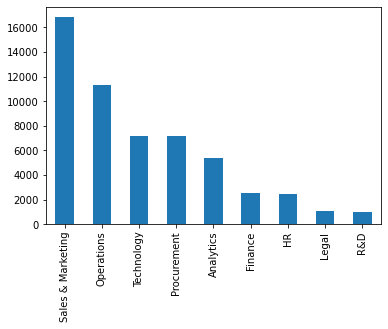

In [19]:
train_df.department.value_counts().plot(kind="bar")

### Count of employees w.r.t. 'region'

<AxesSubplot:>

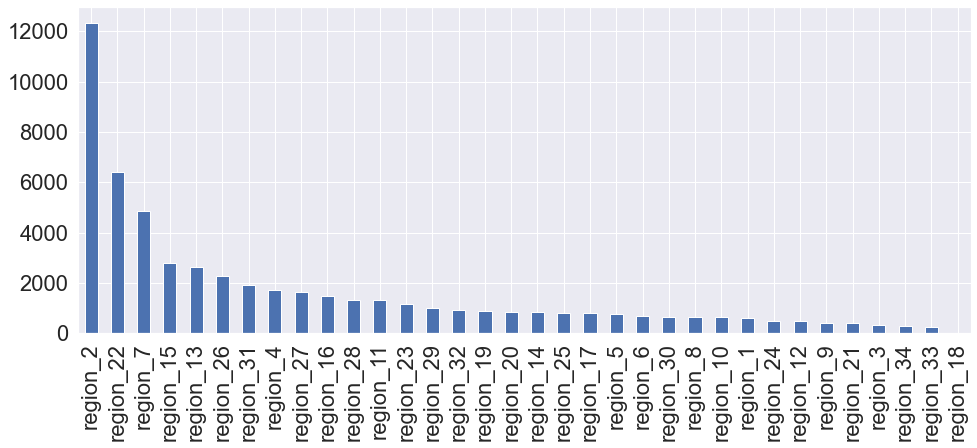

In [20]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
train_df.region.value_counts().plot(kind="bar")

## **Distribution of Education across Employees**

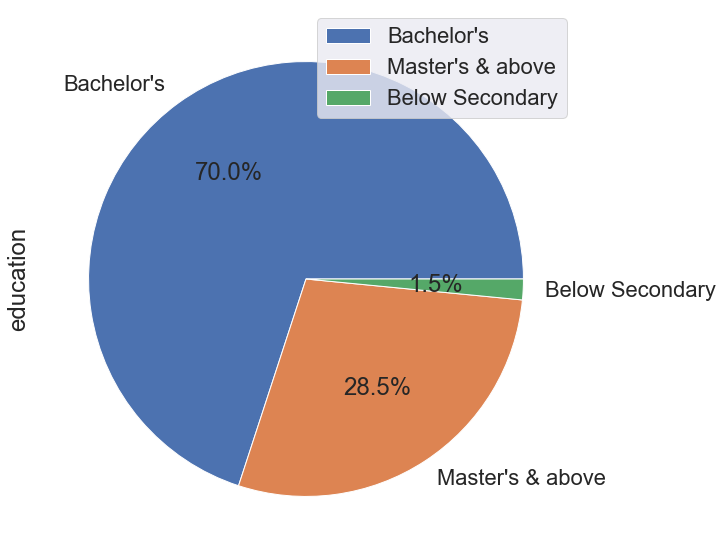

In [21]:
train_df["education"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(10, 10), startangle=0).legend()

## **Gender distribution across employees**

<AxesSubplot:>

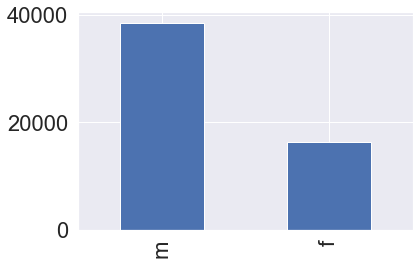

In [22]:
train_df.gender.value_counts().plot(kind = "bar")
# m = male, f= female

## **Distribution of no. of trainings provided to employees**

<AxesSubplot:xlabel='no_of_trainings', ylabel='count'>

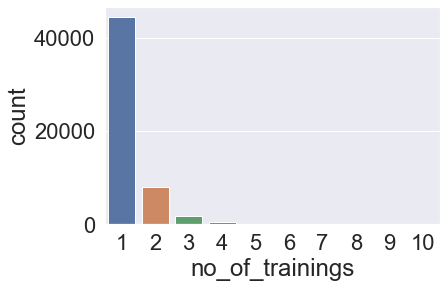

In [23]:
sns.countplot(x=train_df["no_of_trainings"])

<AxesSubplot:ylabel='Frequency'>

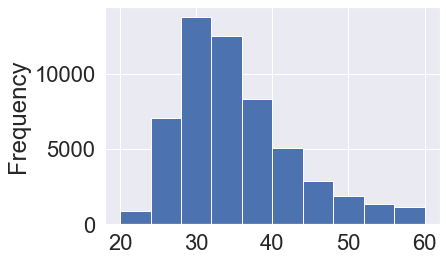

In [24]:
train_df["age"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

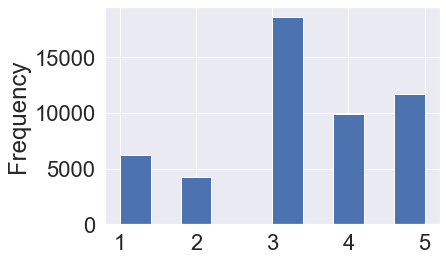

In [25]:
train_df["previous_year_rating"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

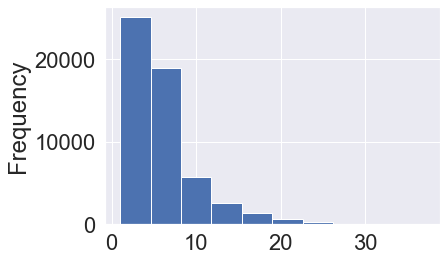

In [26]:
train_df["length_of_service"].plot.hist()

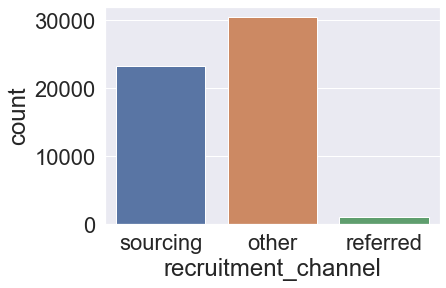

In [27]:
sns.countplot(data=train_df, x = "recruitment_channel")
plt.show()

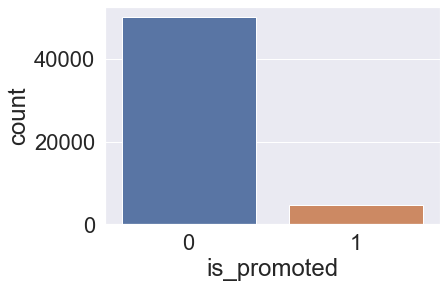

In [28]:
sns.countplot(data=train_df, x = "is_promoted")
plt.show()

### As we can see, the data is highly skewed and is imbalanced because the number of not promoted employees is more than almost 12 times that of number employees promoted.

### **Average Training Score according to whether awards won**

<AxesSubplot:xlabel='avg_training_score', ylabel='Count'>

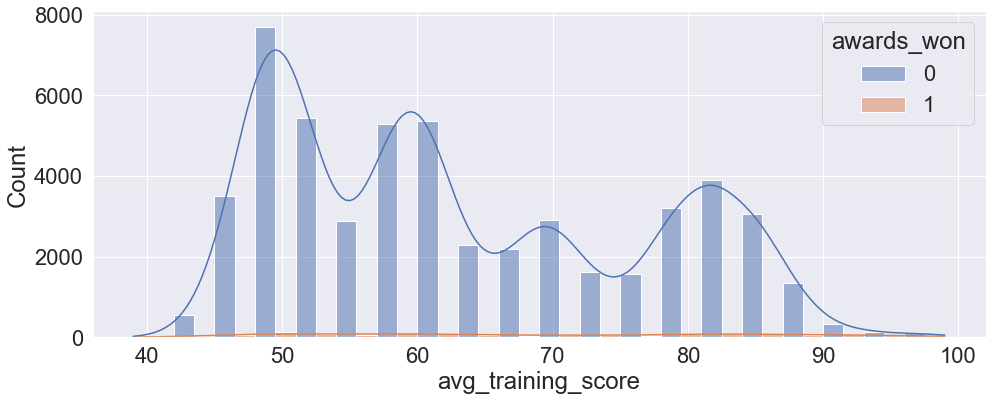

In [29]:
plt.figure(figsize=(16, 6))
sns.histplot(data=train_df, x="avg_training_score", kde=True, hue='awards_won', binwidth=3, multiple="dodge")

### **Plots of is_promoted w.r.t. other variables**

#### **Department and Gender Wise**

<Figure size 1152x432 with 0 Axes>

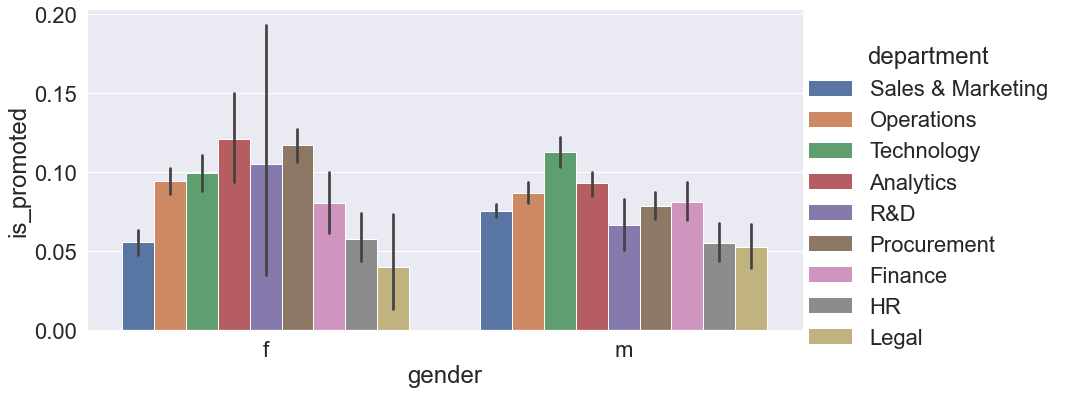

In [30]:
plt.figure(figsize=(16, 6))
sns.catplot(x="gender", y="is_promoted", hue="department", kind="bar", data=train_df, height=6, aspect=2)

#### **Education Wise**

<Figure size 1152x432 with 0 Axes>

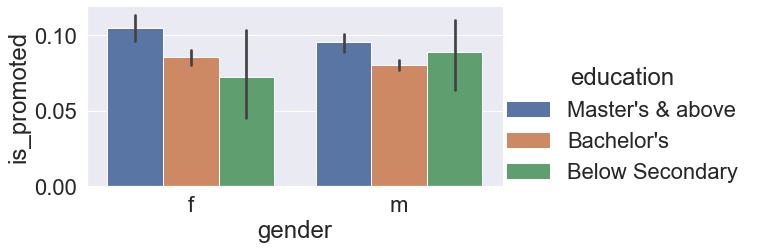

In [31]:
plt.figure(figsize=(16, 6))
sns.catplot(x="gender", y="is_promoted", hue="education", kind="bar", data=train_df, height=4, aspect=2)

#### **Recruitment Channel and Gender wise**

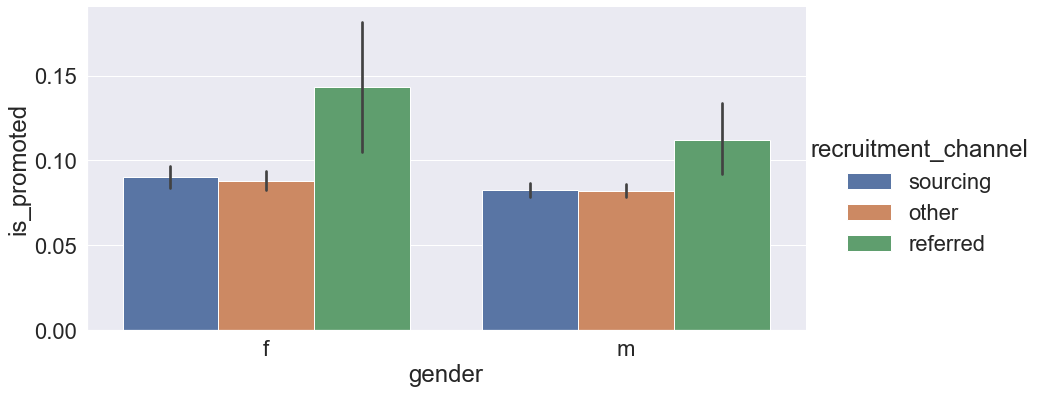

In [32]:
sns.catplot(x="gender", y="is_promoted", hue="recruitment_channel", kind="bar", data=train_df, height=6, aspect=2)

#### **Department Wise**

<Figure size 1152x432 with 0 Axes>

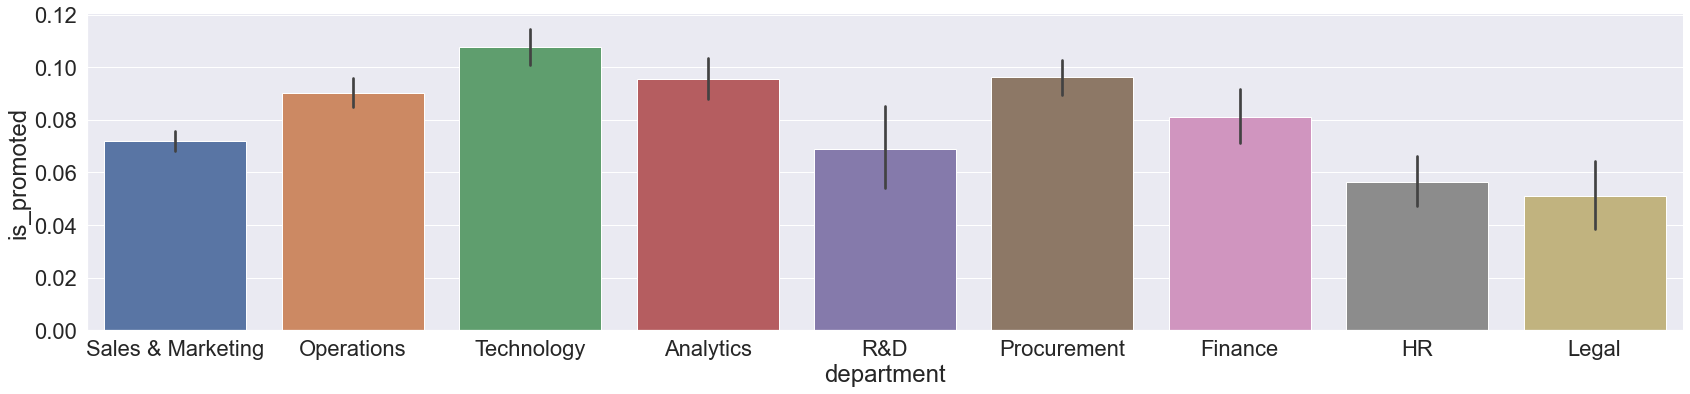

In [33]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
sns.catplot(x="department", y="is_promoted", kind="bar", data=train_df, height=6, aspect=4)

#### **Length of Service**

<Figure size 1152x432 with 0 Axes>

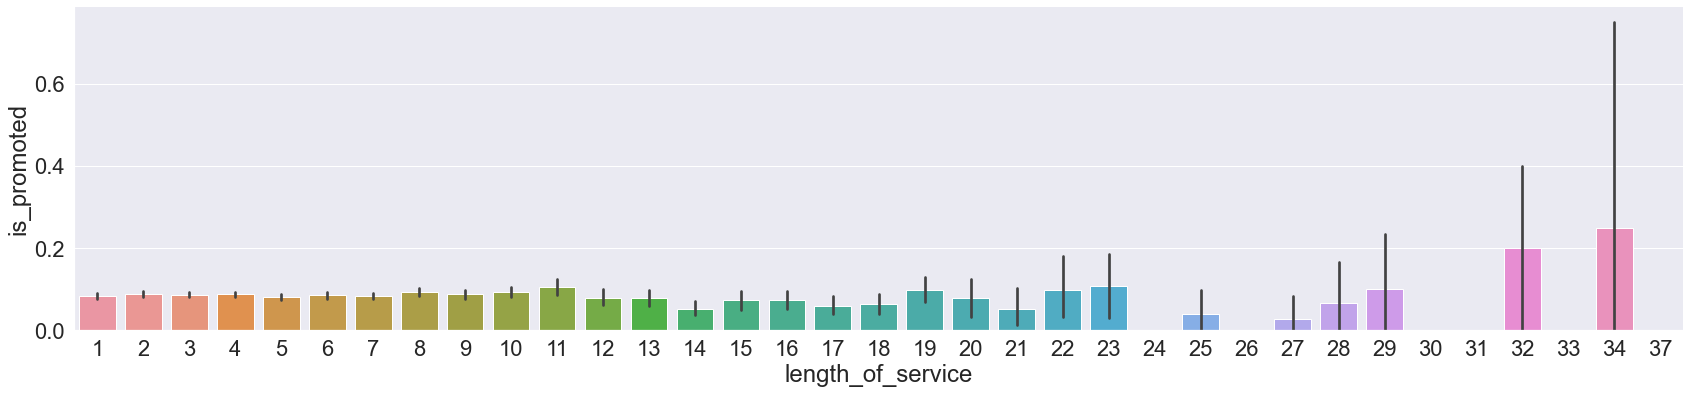

In [34]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
sns.catplot(x="length_of_service", y="is_promoted", kind="bar", data=train_df, height=6, aspect=4)

#### **Department and Awards won**

<Figure size 1152x432 with 0 Axes>

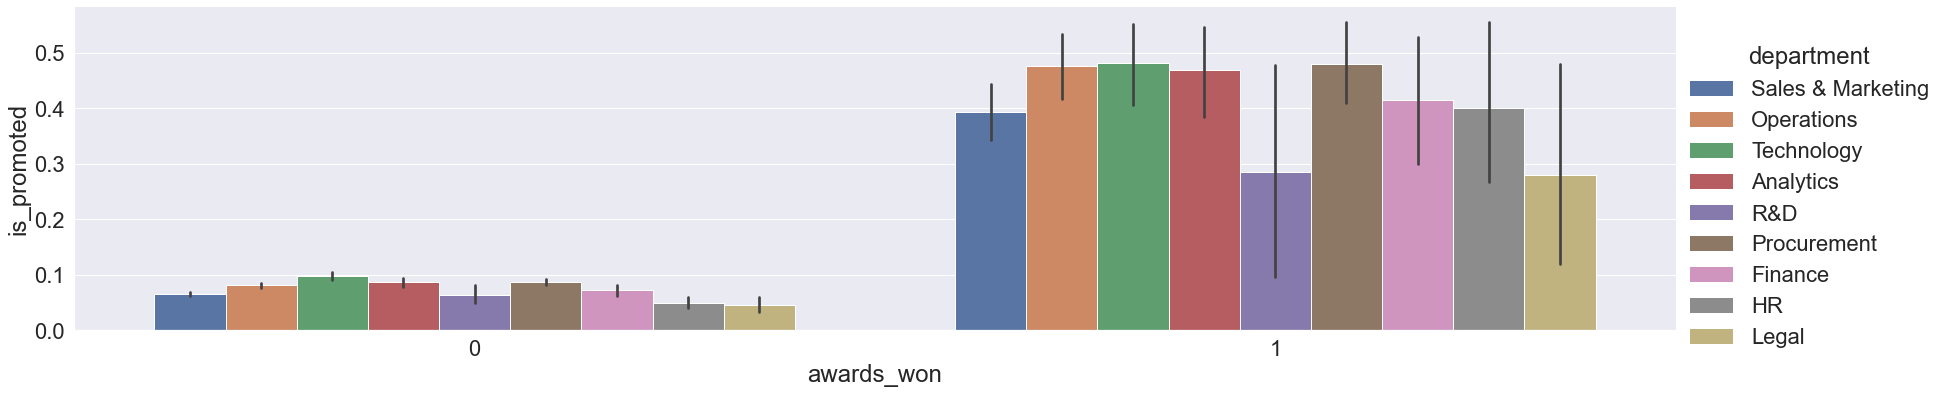

In [35]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
sns.catplot(x="awards_won", y="is_promoted", kind="bar", hue='department', data=train_df, height=6, aspect=4)

In [36]:
# Compare target column with region,education,gender column
pd.crosstab(train_df.region, train_df.is_promoted, rownames=['Regions'], colnames=['Promoted or Not'], margins=True, margins_name="Total")

Promoted or Not,0,1,Total
Regions,,,
region_1,552,58,610
region_10,597,51,648
region_11,1241,74,1315
region_12,467,33,500
region_13,2418,230,2648
region_14,765,62,827
region_15,2586,222,2808
region_16,1363,102,1465
region_17,687,109,796


<AxesSubplot:xlabel='education', ylabel='Count'>

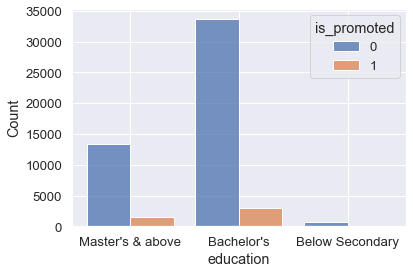

In [37]:
sns.set(font_scale = 1.2)
sns.histplot(data=train_df, x="education", hue="is_promoted", multiple="dodge", shrink=.8)

## **DATA WRANGLING**

In [38]:
train_df = pd.get_dummies(train_df, columns = ['department',	'region',	'education',	'gender',	'recruitment_channel'])

In [39]:
train_df.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPI_morethan_80,awards_won,avg_training_score,is_promoted,department_Analytics,...,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,1,35,5.0,8,1,0,49,0,0,...,0,0,0,0,1,1,0,0,0,1
1,65141,1,30,5.0,4,0,0,60,0,0,...,0,0,1,0,0,0,1,1,0,0
2,7513,1,34,3.0,7,0,0,50,0,0,...,0,0,1,0,0,0,1,0,0,1
3,2542,2,39,1.0,10,0,0,50,0,0,...,0,0,1,0,0,0,1,1,0,0
4,48945,1,45,3.0,2,0,0,73,0,0,...,0,0,1,0,0,0,1,1,0,0


In [40]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(train_df)
train_data = pd.DataFrame(imputed, columns=train_df.columns)

In [41]:
round(abs(train_data.corr()['is_promoted']*100).sort_values(ascending=False), 2)

is_promoted                     100.00
KPI_morethan_80                  22.16
awards_won                       19.59
avg_training_score               18.11
previous_year_rating             15.22
region_region_4                   3.80
region_region_22                  3.79
department_Sales & Marketing      3.13
department_Technology             3.11
education_Master's & above        2.93
no_of_trainings                   2.49
region_region_7                   2.38
region_region_17                  2.25
department_HR                     2.23
region_region_9                   2.08
region_region_29                  2.04
region_region_32                  2.03
region_region_31                  1.94
recruitment_channel_referred      1.86
region_region_25                  1.79
region_region_28                  1.78
region_region_24                  1.72
age                               1.72
department_Legal                  1.70
region_region_5                   1.68
region_region_23         

<Figure size 1440x432 with 0 Axes>

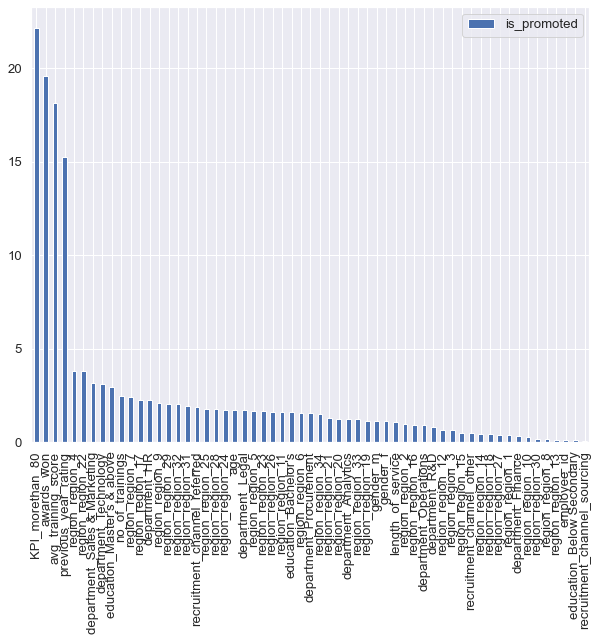

In [42]:
plt.figure(figsize=(20, 6))
pd.DataFrame(abs(train_data.corr()['is_promoted'].drop('is_promoted')*100).sort_values(ascending=False)).plot.bar(figsize = (10,8))
plt.show()

In [43]:
X = train_data.drop(['is_promoted'], axis = 1)
y = train_data['is_promoted']

### Balancing the dataset using SMOTETomek method of Random Up-Sampling and Down-Sampling

In [44]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

train_data = train_data.sample(frac=1)

from imblearn.combine import SMOTETomek 

smt = SMOTETomek(random_state=42)

X_res, y_res = smt.fit_resample(X, y)

X_res.shape

(95986, 59)

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

## MODEL BUILDING

### Comparing F1 Score of various models

In [99]:
from sklearn.metrics import f1_score

sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

score_sgd = f1_score(y_test, Y_pred, average='macro')

In [100]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

score_log = f1_score(y_test, Y_pred, average='macro')

In [101]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
score_knn = f1_score(y_test, Y_pred, average='macro')

In [102]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
score_gaussian = f1_score(y_test, Y_pred, average='macro')

In [103]:
perceptron = Perceptron(max_iter=100)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

score_perceptron = f1_score(y_test, Y_pred, average='macro')

In [104]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
score_decision_tree = f1_score(y_test, Y_pred, average='macro')

In [105]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
score_random_forest = f1_score(y_test, Y_prediction, average='macro')

In [106]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(X_train, Y_train)

Y_pred = AdaBoost.predict(X_test)

score_AdaBoost = f1_score(y_test, Y_pred, average='macro')

In [107]:
XGBoost = XGBClassifier()
XGBoost.fit(X_train, Y_train)

Y_predicted = XGBoost.predict(X_test)

score_XGBoost = f1_score(y_test, Y_predicted, average='macro')

In [108]:
from sklearn.neural_network import MLPClassifier

MLPClassifier = MLPClassifier()
MLPClassifier.fit(X_train, Y_train)
Y_pred = MLPClassifier.predict(X_test)

score_MLPClassifier = f1_score(y_test, Y_pred, average='macro')

In [109]:
# comparing all the models

results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression','Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent','Decision Tree', 'XG Boost', 'AdaBoost', 'Neural Network'],
    'Macro F1 Score': [score_knn, score_log, score_random_forest, score_gaussian, score_perceptron, score_sgd, 
              score_decision_tree, score_XGBoost, score_AdaBoost, score_MLPClassifier]})
result_df = results.sort_values(by='Macro F1 Score', ascending=False)
result_df = result_df.set_index('Macro F1 Score')
result_df

,Model
Macro F1 Score,
0.965844,XG Boost
0.962615,Random Forest
0.945174,AdaBoost
0.941690,Decision Tree
0.805925,KNN
0.681743,Logistic Regression
0.670861,Naive Bayes
0.405937,Neural Network
0.343562,Perceptron


In [57]:
from sklearn.metrics import classification_report

# Random Forest
print(classification_report(y_test, Y_prediction))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     15829
         1.0       1.00      0.93      0.96     15847

    accuracy                           0.96     31676
   macro avg       0.96      0.96      0.96     31676
weighted avg       0.96      0.96      0.96     31676



In [58]:
# XGBoost
print(classification_report(y_test, Y_predicted))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     15829
         1.0       1.00      0.94      0.96     15847

    accuracy                           0.97     31676
   macro avg       0.97      0.97      0.97     31676
weighted avg       0.97      0.97      0.97     31676



### Balancing the dataset using SMOTEENN method of Random Up-Sampling and Down-Sampling

In [110]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

train_data = train_data.sample(frac=1)

from imblearn.combine import SMOTEENN 

sme = SMOTEENN(random_state=42)

X_res1, y_res1 = sme.fit_resample(X, y)

X_res1.shape

(64793, 59)

In [111]:
X_train, X_test, Y_train, y_test = train_test_split(X_res1, y_res1, test_size=0.33, random_state=42)

## MODEL BUILDING

### Comparing F1 Score of various models

In [113]:
from sklearn.metrics import f1_score

sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

score_sgd = f1_score(y_test, Y_pred, average='macro')

In [114]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

score_log = f1_score(y_test, Y_pred, average='macro')

In [115]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
score_knn = f1_score(y_test, Y_pred, average='macro')

In [116]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
score_gaussian = f1_score(y_test, Y_pred, average='macro')

In [117]:
perceptron = Perceptron(max_iter=100)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

score_perceptron = f1_score(y_test, Y_pred, average='macro')

In [118]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
score_decision_tree = f1_score(y_test, Y_pred, average='macro')

In [119]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
score_random_forest = f1_score(y_test, Y_prediction, average='macro')

In [120]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(X_train, Y_train)

Y_pred = AdaBoost.predict(X_test)

score_AdaBoost = f1_score(y_test, Y_pred, average='macro')

In [121]:
XGBoost = XGBClassifier()
XGBoost.fit(X_train, Y_train)

Y_predicted = XGBoost.predict(X_test)

score_XGBoost = f1_score(y_test, Y_predicted, average='macro')

In [122]:
from sklearn.neural_network import MLPClassifier

MLPClassifier = MLPClassifier()
MLPClassifier.fit(X_train, Y_train)
Y_pred = MLPClassifier.predict(X_test)

score_MLPClassifier = f1_score(y_test, Y_pred, average='macro')

In [123]:
# comparing all the models

results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression','Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent','Decision Tree', 'XG Boost', 'AdaBoost', 'Neural Network'],
    'Macro F1 Score': [score_knn, score_log, score_random_forest, score_gaussian, score_perceptron, score_sgd, 
              score_decision_tree, score_XGBoost, score_AdaBoost, score_MLPClassifier]})
result_df = results.sort_values(by='Macro F1 Score', ascending=False)
result_df = result_df.set_index('Macro F1 Score')
result_df

,Model
Macro F1 Score,
0.958813,XG Boost
0.955783,Random Forest
0.950069,KNN
0.935886,Decision Tree
0.926873,AdaBoost
0.734522,Naive Bayes
0.679448,Logistic Regression
0.636121,Neural Network
0.373017,Stochastic Gradient Decent


In [72]:
from sklearn.metrics import classification_report

# Random Forest
print(classification_report(y_test, Y_prediction))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      8661
         1.0       0.99      0.94      0.96     12721

    accuracy                           0.96     21382
   macro avg       0.95      0.96      0.96     21382
weighted avg       0.96      0.96      0.96     21382



In [73]:
# XGBoost
print(classification_report(y_test, Y_predicted))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      8661
         1.0       0.99      0.94      0.97     12721

    accuracy                           0.96     21382
   macro avg       0.96      0.96      0.96     21382
weighted avg       0.96      0.96      0.96     21382



### Its evident from the above results that the SMOTETomek method of balancing the dataset gives us better F1 scores of all models, and over that we get the top 3 models as:
1. XGBoost
2. Random Forest
3. AdaBoost / KNN
Further working to improve our XGBoost model.

### Train-Test Split

In [74]:
X_train, X_test, Y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

### Stratified K-fold Cross Validation

In [75]:
# STRATIFIED K-FOLD CROSS VALIDATION { 10-fold }
  
# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X_res.loc[train_index], X_res.loc[test_index]
    y_train_fold, y_test_fold = y_res.loc[train_index], y_res.loc[test_index]
    XGBoost.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(XGBoost.score(x_test_fold, y_test_fold))

# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9405218025907681, 0.9456303594234629, 0.9439883232986681, 0.9368728334245575, 0.9452654625068418, 0.9439883232986681, 0.9379675241744208, 0.9425287356321839, 0.9452554744525548, 0.9421532846715328]

Maximum Accuracy That can be obtained from this model is: 94.56303594234629 %

Minimum Accuracy: 93.68728334245576 %

Overall Accuracy: 94.24172123473659 %

Standard Deviation is: 0.003084799471361375


In [76]:
cv_results = cross_val_score(XGBoost, X_res, y_res, cv=skf, scoring='accuracy', verbose=10)
print('')
print(f'The mean of the performance over all folds = {cv_results.mean()*100:.2f}' + '%')

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.967) total time=  19.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


[CV] END ................................ score: (test=0.967) total time=  20.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.4s remaining:    0.0s


[CV] END ................................ score: (test=0.969) total time=  19.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   60.0s remaining:    0.0s


[CV] END ................................ score: (test=0.969) total time=  19.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] END ................................ score: (test=0.969) total time=  19.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.963) total time=  19.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.0min remaining:    0.0s


[CV] END ................................ score: (test=0.967) total time=  20.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=0.968) total time=  19.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s


[CV] END ................................ score: (test=0.968) total time=  19.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.0min remaining:    0.0s


[CV] END ................................ score: (test=0.969) total time=  19.4s

The mean of the performance over all folds = 96.76%


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.3min finished


### Hyperparameter Tuning

In [77]:
# Hyperparameter Tuning of XGBoost model using RandomizedsearchCV

from sklearn.model_selection import RandomizedSearchCV

def random_search_tuning():

    params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'num_class': [10]
              }

    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(X_train, Y_train)

    best_combination = clf.best_params_
   

    return best_combination

if __name__ == '__main__':

    best_params = random_search_tuning()

    print("Best hyperparameter combination: ", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameter combination:  {'subsample': 0.8999999999999999, 'num_class': 10, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}


### XGBoost tuned model and Classification Report

In [80]:
#XGBoost_tuned_Model

XGBoost_tuned = XGBClassifier(max_depth= 10, learning_rate= 0.1,n_estimators= 250, 
                              subsample= 0.8999999999999999, colsample_bytree= 0.6, colsample_bylevel= 0.7 )
XGBoost_tuned.fit(X_train, Y_train)

Y_predicted_tuned = XGBoost_tuned.predict(X_test)

score_XGBoost_tuned = f1_score(y_test, Y_predicted_tuned, average='weighted')
score_XGBoost_tuned

0.9660041696733401

In [81]:
# XGBoost_tuned_Classification_report

print(classification_report(y_test, Y_predicted_tuned))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     15829
         1.0       0.99      0.94      0.97     15847

    accuracy                           0.97     31676
   macro avg       0.97      0.97      0.97     31676
weighted avg       0.97      0.97      0.97     31676



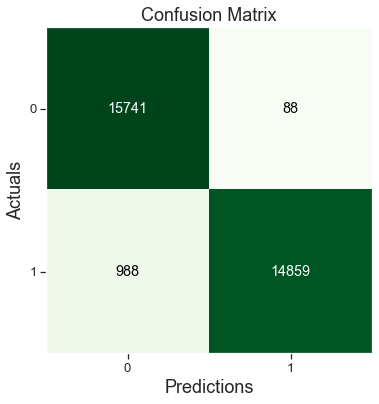

In [96]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=Y_predicted_tuned)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### ROC Curve and ROC-AUC Score

In [82]:
from sklearn.metrics import roc_curve

# Make predictions with probabilities
y_probs = XGBoost_tuned.predict_proba(X_test)

# Keep the probabilites of the positive class only
y_probs = y_probs[:, 1]

# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

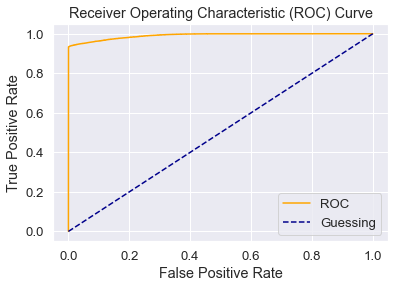

In [83]:
def plot_roc_curve(fpr, tpr):
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
   
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

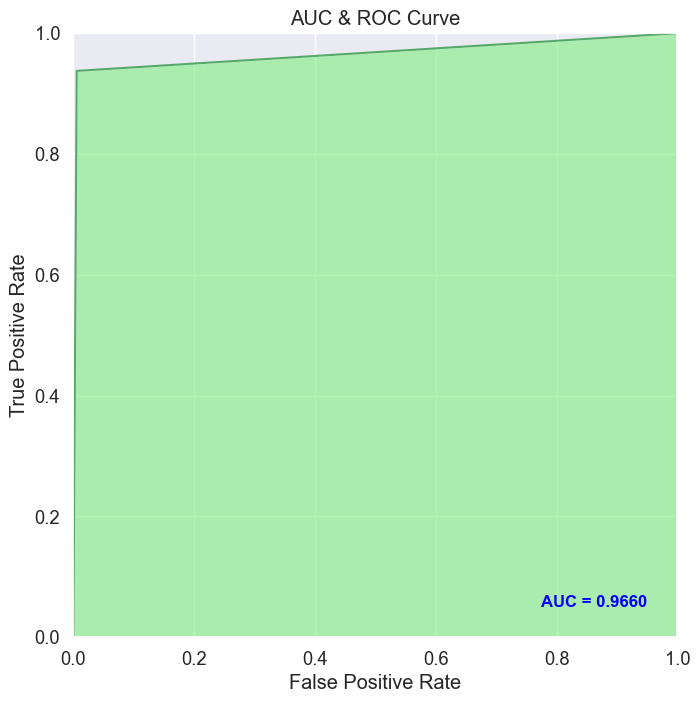

In [84]:
from sklearn import metrics

auc = metrics.roc_auc_score(y_test, Y_predicted_tuned)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, Y_predicted_tuned)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### PR Curve and PR-AUC Score

In [85]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve

# The average precision (PR AUC) is returned by passing the true label & the probability estimate.
# Average precision score
average_precision = average_precision_score(y_test, y_probs)
print(f'The average Precision comes out to be = {average_precision}')
print('')

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(f'The Precision Recall AUC Score is = {auc_precision_recall}')

The average Precision comes out to be = 0.9923697442973275

The Precision Recall AUC Score is = 0.992369540520321


C:\Users\devan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Binary class Precision-Recall curve: AP=0.99')

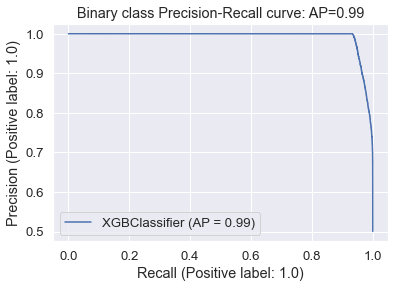

In [87]:
disp = plot_precision_recall_curve(XGBoost_tuned, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Using Model on the unseen test dataset

In [88]:
test_df1 = pd.read_csv("test_2umaH9m.csv") # 'DataFrame' shortened to 'df'
test_df1.rename(columns = {'KPIs_met >80%':'KPI_morethan_80', 'awards_won?':'awards_won'}, inplace = True)
test_df1.shape

(23490, 13)

In [89]:
test_df = pd.get_dummies(test_df1, columns = ['department',	'region',	'education',	'gender',	'recruitment_channel'])
test_df.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPI_morethan_80,awards_won,avg_training_score,department_Analytics,department_Finance,...,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,8724,1,24,NaN,1,1,0,77,0,0,...,0,0,1,0,0,0,1,0,0,1
1,74430,1,31,3.0,5,0,0,51,0,0,...,0,0,1,0,0,1,0,1,0,0
2,72255,1,31,1.0,4,0,0,47,0,0,...,0,0,1,0,0,0,1,1,0,0
3,38562,3,31,2.0,9,0,0,65,0,0,...,0,0,1,0,0,1,0,1,0,0
4,64486,1,30,4.0,7,0,0,61,0,1,...,0,0,1,0,0,0,1,0,0,1


In [90]:
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(test_df)
test_df_imputed = pd.DataFrame(imputed, columns=test_df.columns)

In [124]:
# make predictions for test data
X_test = test_df_imputed
y_pred = XGBoost_tuned.predict(X_test)
predictions = [round(value) for value in y_pred]
test_df1['promoted'] = predictions
test_df_imputed['promoted'] = predictions
test_df1['promoted']
test_df1["promoted"].value_counts()

0    22688
1      802
Name: promoted, dtype: int64

In [125]:
test_df_imputed.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPI_morethan_80,awards_won,avg_training_score,department_Analytics,department_Finance,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,promoted
count,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,...,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.338314,5.810387,0.358834,0.022776,63.263133,0.098723,0.046445,...,0.007663,0.663176,0.015922,0.276884,0.293487,0.706513,0.556748,0.019200,0.424053,0.034142
std,22640.809201,0.600910,7.679492,1.229187,4.207917,0.479668,0.149191,13.411750,0.298296,0.210452,...,0.087203,0.472634,0.125175,0.447468,0.455369,0.455369,0.496780,0.137229,0.494209,0.181598
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


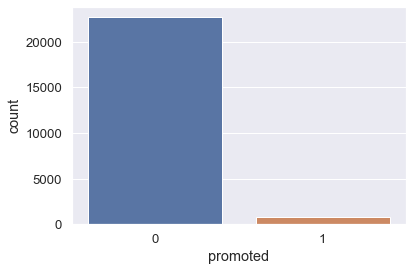

In [126]:
sns.countplot(data=test_df1, x = "promoted")
plt.show()

### **Plots of "promoted" w.r.t. other variables**

#### **Department and Gender Wise**

<Figure size 1152x432 with 0 Axes>

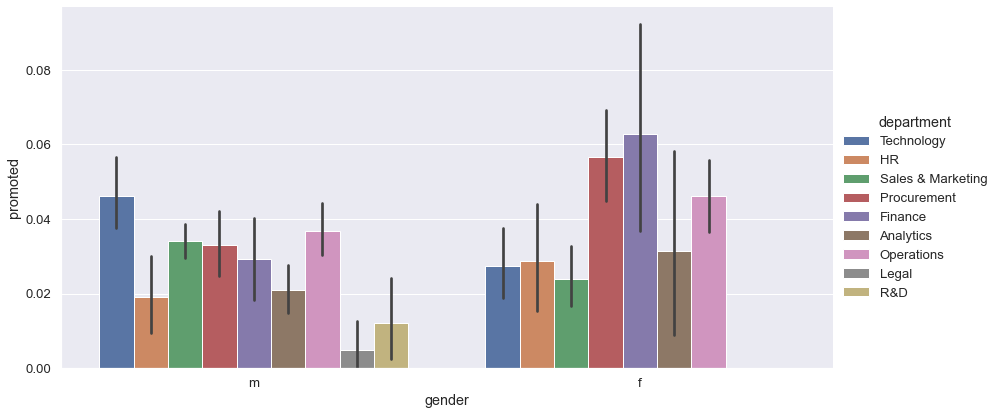

In [127]:
plt.figure(figsize=(16, 6))
sns.catplot(x="gender", y="promoted", hue="department", kind="bar", data=test_df1, height=6, aspect=2)

#### **Education Wise**

<Figure size 1152x432 with 0 Axes>

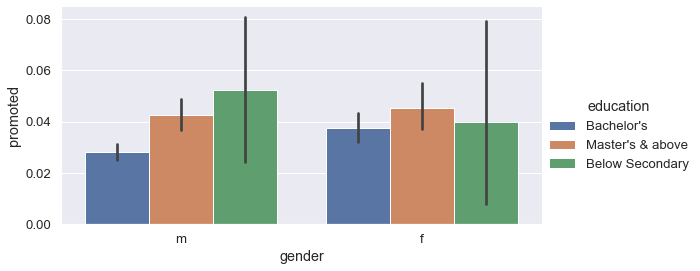

In [128]:
plt.figure(figsize=(16, 6))
sns.catplot(x="gender", y="promoted", hue="education", kind="bar", data=test_df1, height=4, aspect=2)

#### **Recruitment Channel and Gender wise**

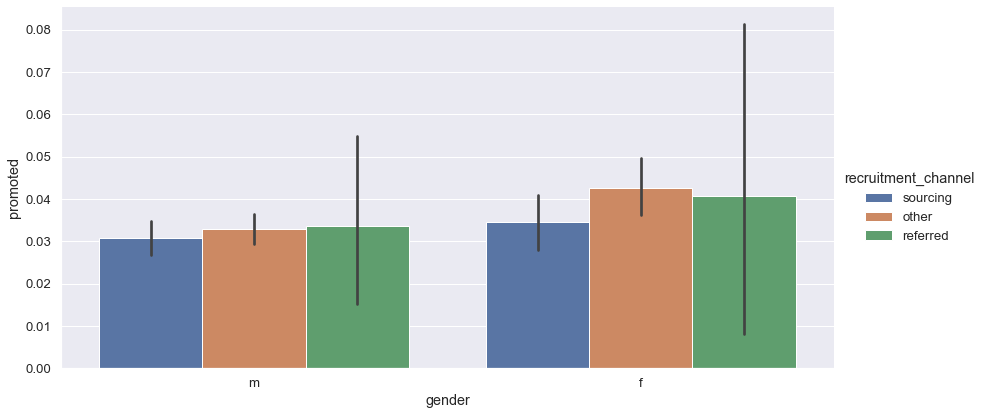

In [129]:
sns.catplot(x="gender", y="promoted", hue="recruitment_channel", kind="bar", data=test_df1, height=6, aspect=2)

#### **Department Wise**

<Figure size 1152x432 with 0 Axes>

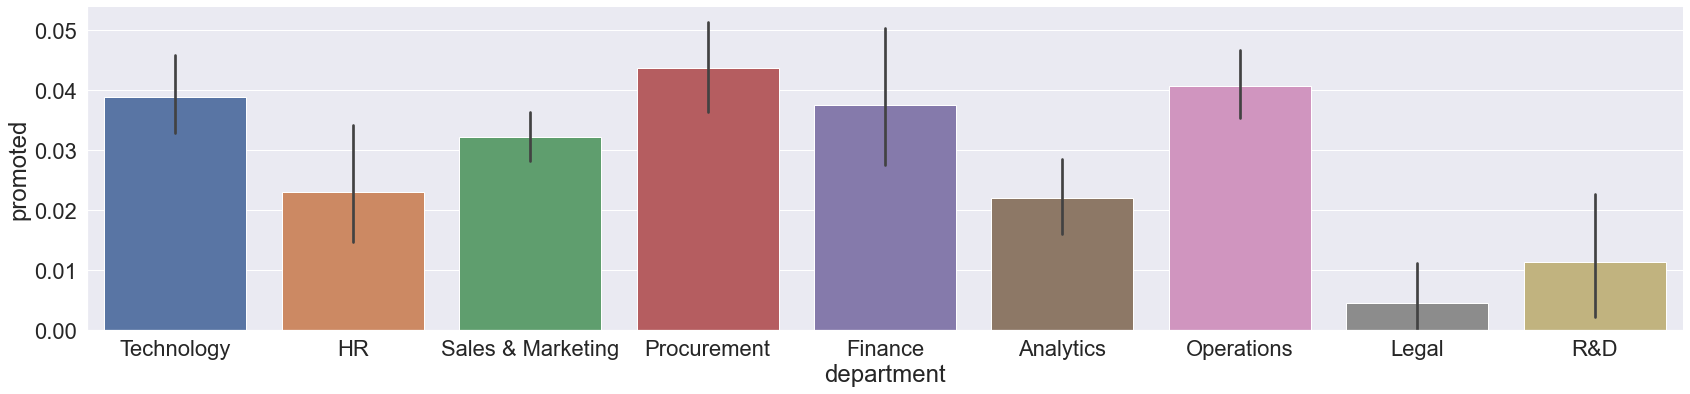

In [130]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
sns.catplot(x="department", y="promoted", kind="bar", data=test_df1, height=6, aspect=4)

#### **Length of Service**

<Figure size 1152x432 with 0 Axes>

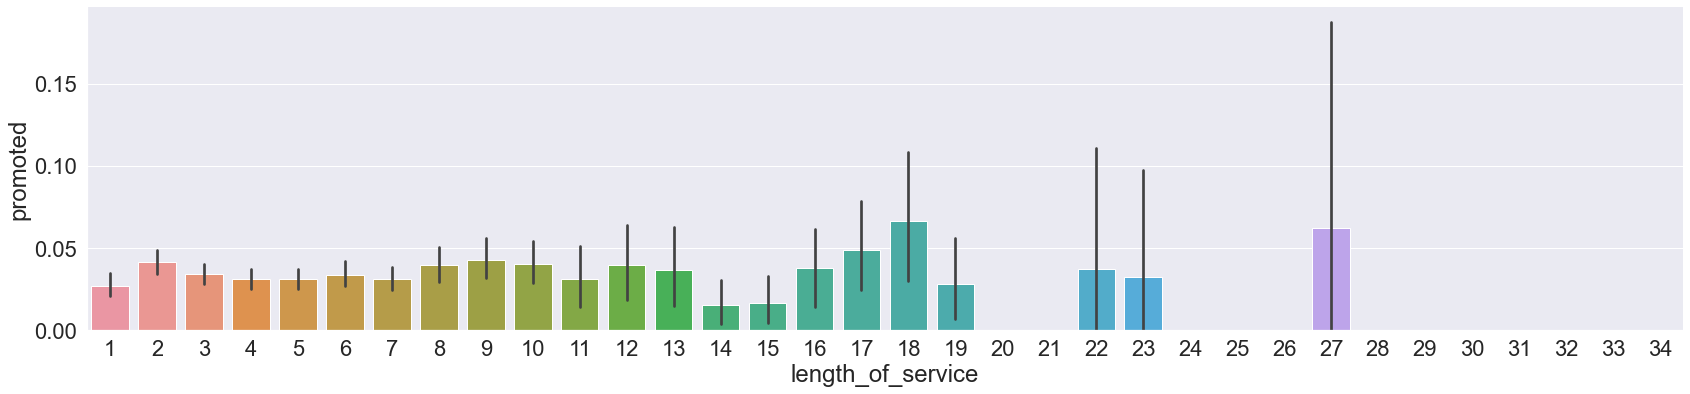

In [131]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
sns.catplot(x="length_of_service", y="promoted", kind="bar", data=test_df1, height=6, aspect=4)

#### **Department and Awards won**

<Figure size 1152x432 with 0 Axes>

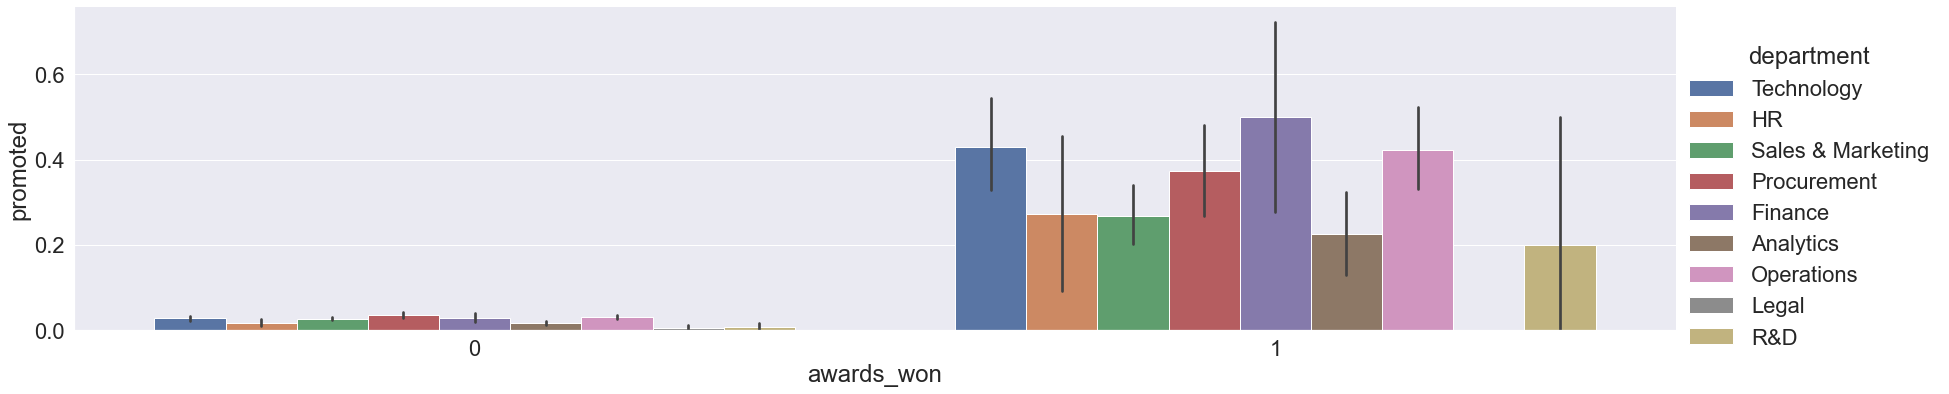

In [132]:
plt.figure(figsize=(16, 6))
sns.set(font_scale = 2)
sns.catplot(x="awards_won", y="promoted", kind="bar", hue='department', data=test_df1, height=6, aspect=4)

In [133]:
# Compare target column with region,education,gender column
pd.crosstab(test_df1.region, test_df1.promoted, rownames=['Regions'], colnames=['Promoted or Not'], margins=True, margins_name="Total")

Promoted or Not,0,1,Total
Regions,,,
region_1,227,11,238
region_10,249,20,269
region_11,562,9,571
region_12,207,8,215
region_13,1121,46,1167
region_14,343,7,350
region_15,1092,38,1130
region_16,576,14,590
region_17,336,25,361


#### Promoted vs Education

<AxesSubplot:xlabel='education', ylabel='Count'>

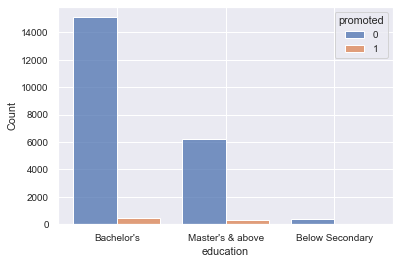

In [134]:
sns.set(font_scale = 0.9)
sns.histplot(data=test_df1, x="education", hue="promoted", multiple="dodge", shrink=.8)